### Import libraries for experiments

In [11]:
import torch
from training_main import training_main, test
from utils import data_loading, normalization, filter_extraction, plot_results, plot_kernels
from CNN import CNN
from ScatNet import ScatNet2D
from kymatio.torch import Scattering2D
from scipy.fft import fft2

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from torchvision.transforms import ToTensor, Compose, Resize, Normalize, ToPILImage
from captum.attr import IntegratedGradients
import cv2

import warnings
warnings.filterwarnings('ignore')


## Data Loading and Normalization

In [2]:
# LOAD DATA
train_data, train_labels, test_data, test_labels = data_loading("./data/train/", "./data/test/")
data = train_data + test_data

# NORMALIZATION
data_transform = normalization(data)

Red ch mean =  0.2082946035683011 
Green ch mean =  0.2082298517705837 
Blue ch mean =  0.2082241406070435
Red ch std =  0.2120124417706629 
Green ch std =  0.211990008277464 
Blue ch std =  0.2119912744425196


In [3]:
print(f"Length train data: {len(train_data)}, length train labels: {len(train_labels)}")
print(f"Length test data: {len(test_data)}, length test labels: {len(test_labels)}")

Length train data: 2600, length train labels: 2600
Length test data: 600, length test labels: 600


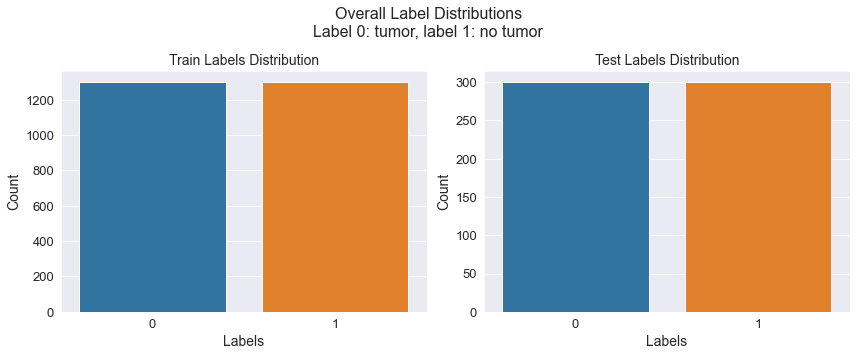

In [12]:
# Barplot to visualize the distribution of the labels 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Train labels
sns.countplot(x=train_labels, ax=ax1)
ax1.set_title('Train Labels Distribution', fontsize=14)
ax1.set_xlabel('Labels')
ax1.set_ylabel('Count')

# Test labels
sns.countplot(x=test_labels, ax=ax2)
ax2.set_title('Test Labels Distribution', fontsize=14)
ax2.set_xlabel('Labels')
ax2.set_ylabel('Count')

plt.suptitle('Overall Label Distributions\nLabel 0: tumor, label 1: no tumor', fontsize=16)
plt.tight_layout()
plt.show()


Example image

Image shape: (512, 512, 3)


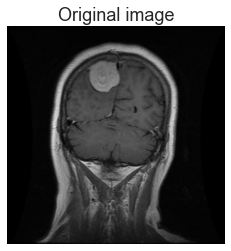

In [13]:
random.seed(42) 
image = random.sample(train_data, 1)
image = np.array(image)
image = np.squeeze(image, 0)
print(f"Image shape: {image.shape}")

plt.imshow(image)
plt.axis('off')
plt.title('Original image')
plt.show()

## CNN

In [14]:
MODEL_NAME = 'CNN'
NUM_FOLD = 10
num_epochs = 20

In [15]:
# LOAD BEST MODEL
max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
index = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(index) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))
model_CNN = CNN(input_channel=3, num_classes=2)
model_CNN.load_state_dict(checkpoint["model_state_dict"])
for parameter in model_CNN.parameters():
    parameter.requires_grad = False


In [16]:
model_CNN

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

ValueError: 'outside upper center' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

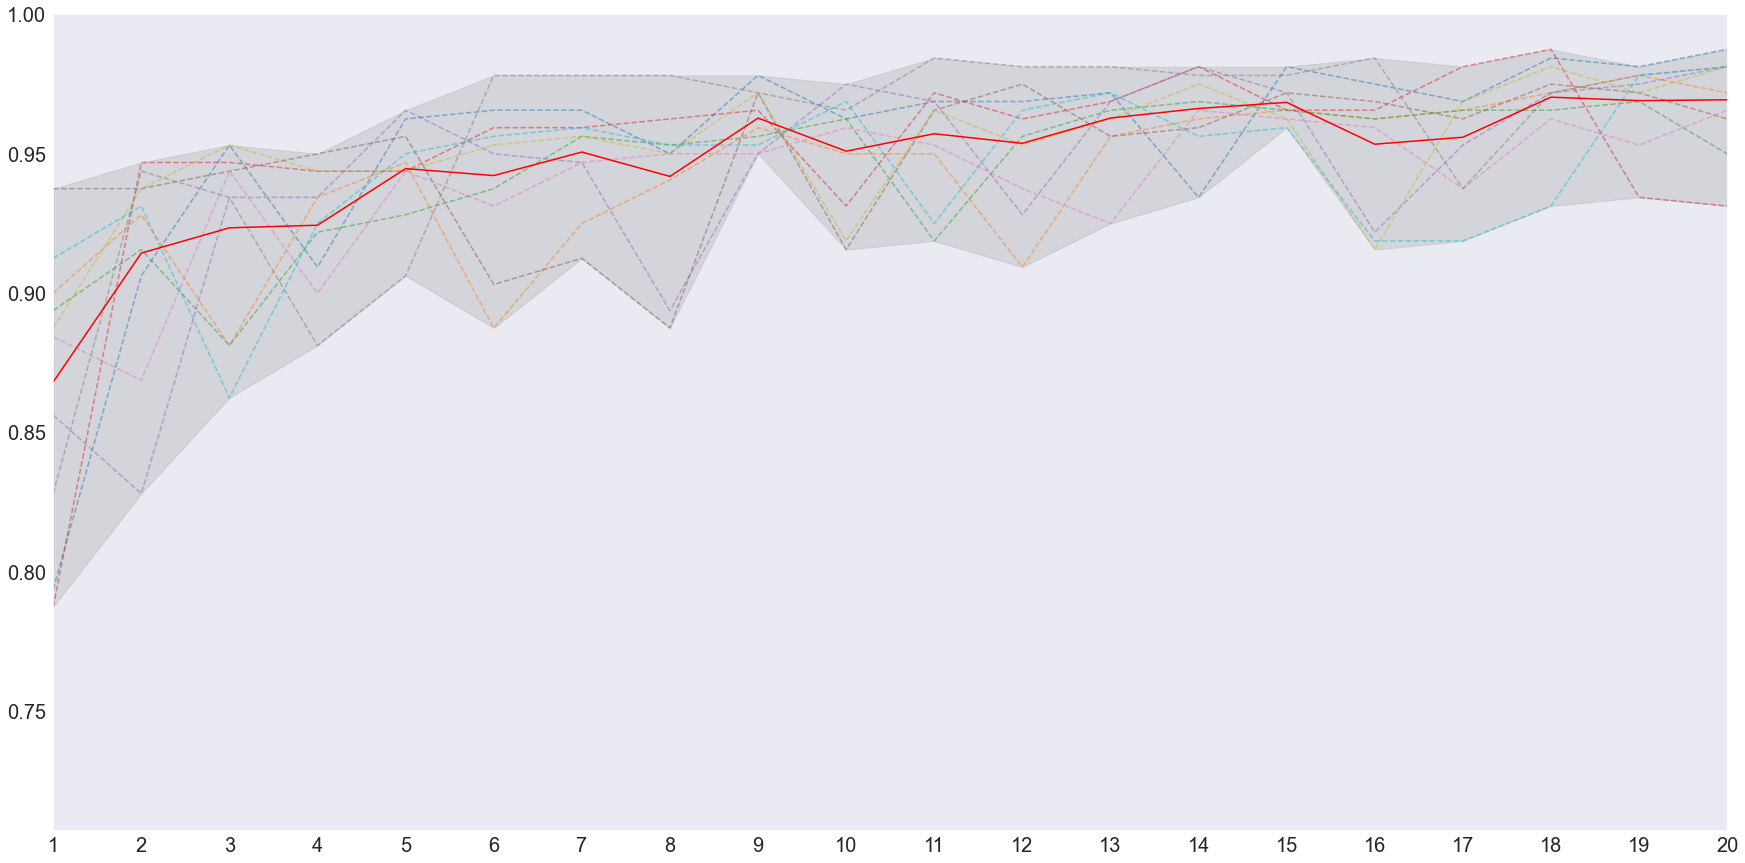

In [17]:
# PLOTTING RESULTS
val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME)

In [ ]:
# TESTING
acc_CNN = test(data_transform, test_data, test_labels, model_CNN, MODEL_NAME, device='cpu')
print("Accuracy", acc_CNN)


### Extract Filters from CNN

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_CNN = model_CNN.to(device)


In [ ]:
# Filter extraction
image = data_transform(image)
image = image.to(device)

single_channel = True if image.shape[0] == 1 else False
filter_extraction(model_CNN, MODEL_NAME, image, single_channel)

## ScatNet 

In [ ]:
MODEL_NAME = 'ScatNet'
NUM_FOLD = 10
num_epochs = 20

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# LOAD BEST MODEL
max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
index = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(index) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))

# Define best model
L = 8
J = 2
scattering = Scattering2D(J=J, shape=(128, 128), L=L)
K = 81  # Input channels for the ScatNet
scattering = scattering.to(device)
model_ScatNet = ScatNet2D(input_channels=K, scattering=scattering, num_classes=2).to(device)
model_ScatNet.load_state_dict(checkpoint["model_state_dict"])

for parameter in model_ScatNet.parameters():
    parameter.requires_grad = False

In [ ]:
model_ScatNet

In [ ]:
# PLOTTING RESULTS
val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME)

In [ ]:
# TESTING
acc_ScatNet = test(data_transform, test_data, test_labels, model_ScatNet, MODEL_NAME, device='cpu')
print("Accuracy", acc_ScatNet)

### Extract Filters from ScatNet

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ScatNet = model_ScatNet.to(device)

In [ ]:
# Filter extraction
scatter = model_ScatNet.scattering
plot_kernels(J, L, scatter, MODEL_NAME)

--------------------------------------------------------------------
## INTEGRATED GRADIENTS

In [61]:
# IG SCRATCH
def ig_scratch(transformed_img, model, baseline, n_alpha):

    img = transformed_img.clone().to('cuda')
    baseline = baseline.to('cuda')
    model = model.to('cuda')

    difference_img_baseline = (img - baseline).reshape(3,128,128).to('cuda')

    alphas = torch.linspace(0, 1, n_alpha) 
    gradients_list = torch.empty(0,3,128,128).to('cuda')

    model.eval()
    for alpha in alphas:
        input = (baseline.reshape(3,128,128) + (alpha * difference_img_baseline)).reshape(1,3,128,128).to('cuda').requires_grad_(True)

        output = model(input)
        
        
        #gradients = torch.autograd.grad(torch.max(output), input)[0] 

        probs = torch.nn.functional.softmax(output, dim=1)[:,1]
        gradients = torch.autograd.grad(probs, input, 
								grad_outputs=torch.ones_like(probs),
							 	create_graph=True)[0] 

        gradients_list = torch.cat([gradients_list, gradients],dim=0)

    grads = (gradients_list[:-1] + gradients_list[1:]) / torch.Tensor([2.0]).to('cuda')

    # print(f'grad: {grads.shape}')
    # print(f'grad_list: {gradients_list.shape}')
    # print(f'grad_list_no_last: {gradients_list[:-1].shape}')
    
    avg_grads = torch.mean(grads.detach(), axis=0)
    

    #gradients_list = torch.sum(gradients_list, dim=0).reshape(1,3,128,128)
    
    gradients_list = difference_img_baseline * avg_grads

    # print(f'avg_grad: {avg_grads.shape}')
    # print(f'diff: {difference_img_baseline.shape}')
    
    gradients_list = torch.sum(torch.abs(gradients_list), dim=0)

    gradients_list = (gradients_list - gradients_list.min()) / (gradients_list.max() - gradients_list.min())

    return gradients_list
   

In [54]:
# IG CAPTUM
def ig_captum(transformed_img, model, baseline, n_alpha):
    img = transformed_img.to('cuda')
    model = model.to('cuda')
    baseline = baseline.to('cuda')

    ig = IntegratedGradients(model)
    attributions, delta = ig.attribute(img, baseline, target=0, return_convergence_delta=True, n_steps=n_alpha)

    attributions = torch.sum(torch.abs(attributions), dim=1)
    attributions = (attributions - torch.min(attributions)) / (torch.max(attributions) - torch.min(attributions))
    attributions = attributions.squeeze()

    return attributions

Test and plot the attributions for 3 different images from test folder.

In [20]:
random.seed(46)
num_images = 3
indices = random.sample(range(len(train_data)), num_images)

images = [train_data[i] for i in indices]
labels = [train_labels[i] for i in indices]


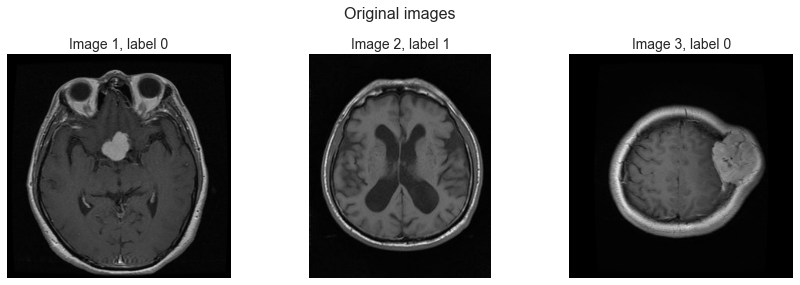

In [22]:
#Plot images
fig, axs = plt.subplots(1, num_images, figsize=(12, 4))

for i in range(num_images):
    image = images[i]
    label = labels[i]

    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f'Image {i+1}, label {label}', fontsize=14)

plt.suptitle('Original images', fontsize=16)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


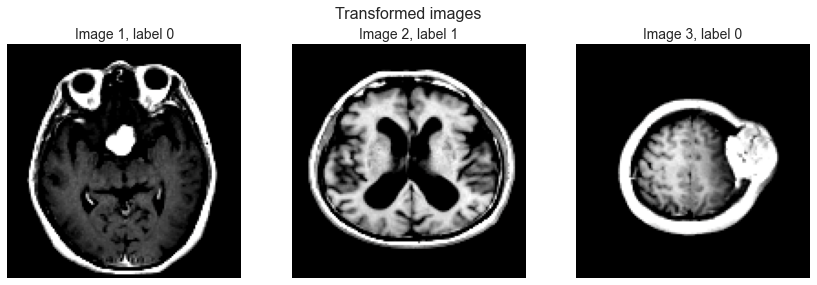

In [23]:
# Apply transform to images
for i in range(num_images):
    images[i] = data_transform(images[i]).unsqueeze(0)

# Plot
fig, axs = plt.subplots(1, num_images, figsize=(12, 4))
for i in range(num_images):
    image = np.squeeze(np.array(images[i]), 0).transpose(1, 2, 0)
    label = labels[i]
    
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title(f'Image {i+1}, label {label}', fontsize=14)

plt.suptitle('Transformed images', fontsize=16)
plt.tight_layout()
plt.show()

### Baseline choices

In [31]:
baseline_zeros = torch.zeros(1, 3, 128, 128)
baseline_uniform = torch.rand(1, 3, 128, 128)

tensor_images = torch.stack([data_transform(img) for img in train_data])
baseline_mean = torch.mean(tensor_images, dim=0, keepdim=True)

baselines = [baseline_zeros, baseline_uniform, baseline_mean]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


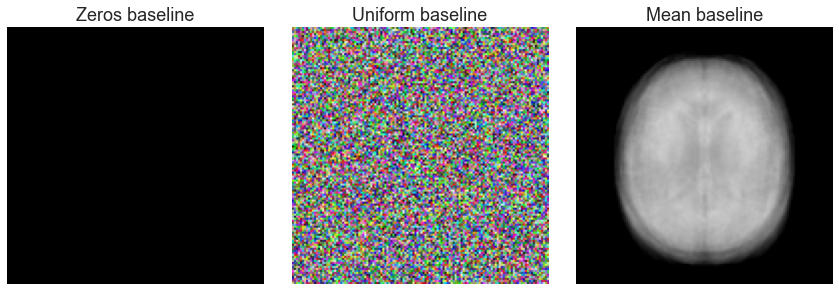

In [26]:
# Plot baselines
fig, axs = plt.subplots(1, len(baselines), figsize=(12, 4))
titles = ['Zeros baseline', 'Uniform baseline', 'Mean baseline']

for i in range(len(baselines)):
    baseline = baselines[i]

    axs[i].imshow(baseline.squeeze().permute(1, 2, 0))
    axs[i].axis('off')
    axs[i].set_title(f'{titles[i]}')

plt.tight_layout()
plt.show()

## Attributions for CNN model

In [76]:
# Attribution plot
def plot_attributions(image, baselines, attributions, titles):

    image = image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    fig, axis = plt.subplots(len(baselines), 3, figsize=(12, 10))

    for i in range(len(baselines)):
        attribution = attributions[i]
        ig_captum = attribution[0].cpu()
        ig_scratch = attribution[1]

        axis[i, 0].imshow(baselines[i].squeeze().permute(1, 2, 0)) #.cpu().detach().numpy()) 
        axis[i, 0].set_xticks([])
        axis[i, 0].set_yticks([])
        axis[i, 0].set_title(titles[i], fontsize=14)

        #im2 = axis[i, 1].imshow(image)
        im2 = axis[i, 1].imshow(ig_captum, cmap='inferno', alpha=0.9)
        axis[i, 1].axis('off')
        axis[i, 1].set_title('IG Captum', fontsize=14)
        divider = make_axes_locatable(axis[i, 1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax, orientation='vertical')

        #im3 = axis[i, 2].imshow(image)
        
        # OLD
        # im3 = axis[i, 2].imshow(np.mean(np.transpose(ig_scratch.squeeze().cpu().detach().numpy(), (1,2,0)), axis=2), cmap='inferno', alpha=0.8)
        # NEW
        im3 = axis[i, 2].imshow(np.transpose(ig_scratch.unsqueeze(0).cpu().detach().numpy(), (1,2,0)), cmap='inferno', alpha=0.8)

        #im3 = axis[i, 2].imshow(ig_scratch.squeeze(0).permute(1,2,0).cpu(), cmap='jet', alpha=0.9)
        axis[i, 2].axis('off')
        axis[i, 2].set_title('IG Scratch', fontsize=14)

        divider = make_axes_locatable(axis[i, 2])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax, orientation='vertical')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.show()

In [28]:
n_alpha = 100
titles = ['Zeros baseline', 'Uniform baseline', 'Mean baseline']

Image 1

In [29]:
image = images[0].to('cuda')
label = labels[0]

# Prediction with best model
model_CNN.eval()
model_CNN.cuda()
with torch.inference_mode():
    pred = model_CNN(image)
    
probs = torch.softmax(pred, dim=1)
prediction = torch.argmax(probs, dim=1)

# model logits -> pred probs -> pred label
print("Output logits: ", pred)
print("Output prediction probabilities: ", probs)
print(f'Output prediction label: {prediction} --> Prediction class: {"NO TUMOR" if prediction.cpu() == 1 else "TUMOR"}')
print(f'Actual label: {label} --> True class: {"NO TUMOR" if label == 1 else "TUMOR"}\n')

Output logits:  tensor([[ 4.8419, -2.3938]], device='cuda:0')
Output prediction probabilities:  tensor([[9.9928e-01, 7.1988e-04]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR



CAPTUM ATTR: torch.Size([1, 3, 128, 128])
CAPTUM ATTR SUM: torch.Size([1, 128, 128])
CAPTUM ATTR: torch.Size([1, 3, 128, 128])
CAPTUM ATTR SUM: torch.Size([1, 128, 128])
CAPTUM ATTR: torch.Size([1, 3, 128, 128])
CAPTUM ATTR SUM: torch.Size([1, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IG SCRATCH: torch.Size([128, 128])
IG SCRATCH: torch.Size([128, 128])
IG SCRATCH: torch.Size([128, 128])


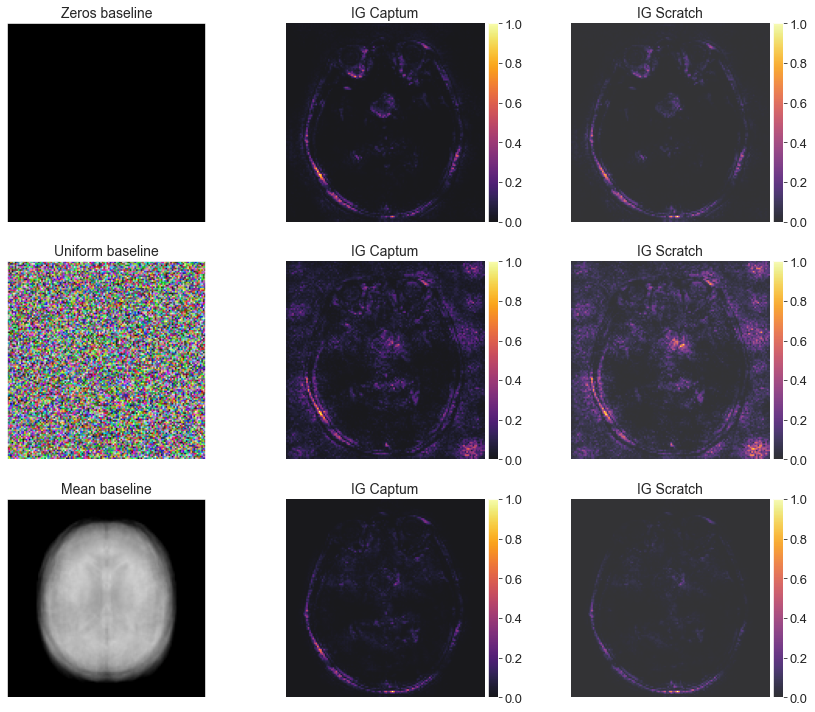

In [75]:
# Compute Integrated Gradients attributions for each baseline (Captum and scratch)
attributions = []
for i in range(len(baselines)):
    attribution_baseline = []

    baseline = baselines[i]
    attribution_captum = ig_captum(image, model_CNN, baseline, n_alpha)
    attribution_baseline.append(attribution_captum)
    attribution_scratch = ig_scratch(image, model_CNN, baseline, n_alpha)
    attribution_baseline.append(attribution_scratch)
    # 
    attributions.append(attribution_baseline)

plot_attributions(image, baselines, attributions, titles)


Image 2

In [26]:
image = images[1].to('cuda')
label = labels[1]

# Prediction with best model
model_CNN.eval()
with torch.inference_mode():
    pred = model_CNN(image)
    
probs = torch.softmax(pred, dim=1)
prediction = torch.argmax(probs, dim=1)

# model logits -> pred probs -> pred label
print("Output logits: ", pred)
print("Output prediction probabilities: ", probs)
print(f'Output prediction label: {prediction} --> Prediction class: {"NO TUMOR" if prediction.cpu() == 1 else "TUMOR"}')
print(f'Actual label: {label} --> True class: {"NO TUMOR" if label == 1 else "TUMOR"}\n')

Output logits:  tensor([[-2.1599,  4.6657]], device='cuda:0')
Output prediction probabilities:  tensor([[0.0011, 0.9989]], device='cuda:0')
Output prediction label: tensor([1], device='cuda:0') --> Prediction class: NO TUMOR
Actual label: 1 --> True class: NO TUMOR



In [18]:
# Compute Integrated Gradients attributions for each baseline (Captum and scratch)
attributions = []
for i in range(len(baselines)):
    attribution_baseline = []

    baseline = baselines[i]
    attribution_captum = ig_captum(image, model_CNN, baseline, n_alpha)
    attribution_baseline.append(attribution_captum)
    attribution_scratch = ig_scratch(image, model_CNN, baseline, n_alpha)
    attribution_baseline.append(attribution_scratch)
    
    attributions.append(attribution_baseline)

plot_attributions(image, baselines, attributions, titles)

AttributeError: 'numpy.ndarray' object has no attribute 'to'

Image 3

In [51]:
image = images[2].to('cuda')
label = labels[2]

# Prediction with best model
model_CNN.eval()
with torch.inference_mode():
    pred = model_CNN(image)
    
probs = torch.softmax(pred, dim=1)
prediction = torch.argmax(probs, dim=1)

# model logits -> pred probs -> pred label
print("Output logits: ", pred)
print("Output prediction probabilities: ", probs)
print(f'Output prediction label: {prediction} --> Prediction class: {"NO TUMOR" if prediction.cpu() == 1 else "TUMOR"}')
print(f'Actual label: {label} --> True class: {"NO TUMOR" if label == 1 else "TUMOR"}\n')

Output logits:  tensor([[ 15.5093, -14.3713]], device='cuda:0')
Output prediction probabilities:  tensor([[1.0000e+00, 1.0545e-13]], device='cuda:0')
Output prediction label: tensor([0], device='cuda:0') --> Prediction class: TUMOR
Actual label: 0 --> True class: TUMOR



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


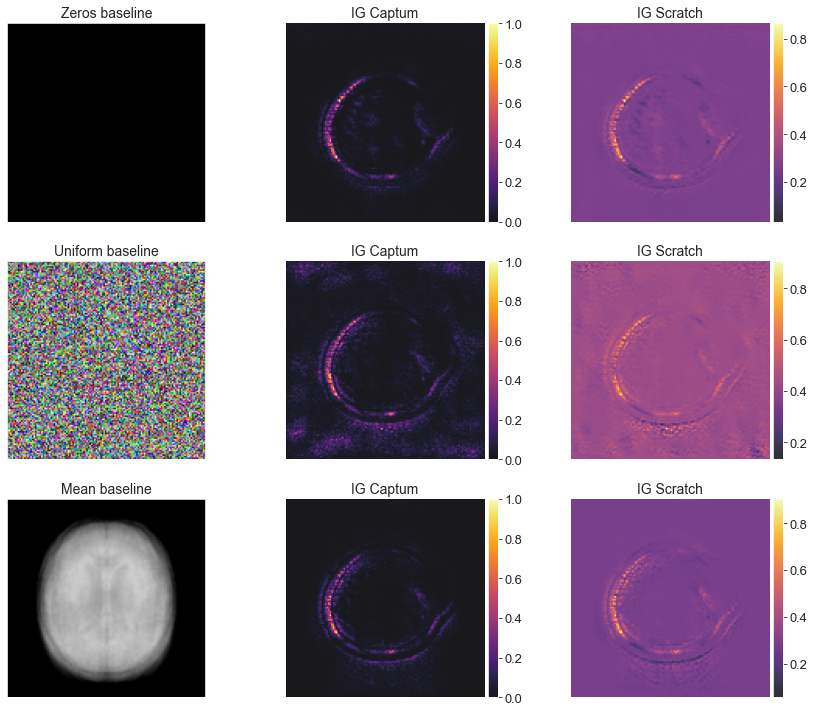

In [54]:
# Compute Integrated Gradients attributions for each baseline (Captum and scratch)
attributions = []
for i in range(len(baselines)):
    attribution_baseline = []

    baseline = baselines[i]
    attribution_captum = ig_captum(image, model_CNN, baseline, n_alpha)
    attribution_baseline.append(attribution_captum)
    attribution_scratch = ig_scratch(image, model_CNN, baseline, n_alpha)
    attribution_baseline.append(attribution_scratch)
    
    attributions.append(attribution_baseline)

plot_attributions(image, baselines, attributions, titles)

### Attributions for ScatNet model

In [ ]:
n_alpha = 100
model = model_ScatNet

ig_captum(image, model_ScatNet, baseline, n_alpha)

In [ ]:
# ScatNet model
print('SCATNET MODEL')
for i in range(num_images):
    print(f'Image {i+1}')
    image = images[i].to('cuda')
    label = labels[i]

    model_ScatNet.eval()
    with torch.inference_mode():
        pred = model_ScatNet(image)
        
    probs = torch.softmax(pred, dim=1)
    prediction = torch.argmax(torch.softmax(pred, dim=1), dim=1)

    # model logits -> pred probs -> pred label
    print("Output logits: ", pred)
    print("Output prediction probabilities: ", probs)
    print(f'Output prediction label: {prediction} --> Prediction class: {"NO TUMOR" if prediction.cpu() == 1 else "TUMOR"}')
    print(f'Actual label: {label} --> True class: {"NO TUMOR" if label == 1 else "TUMOR"}\n')